In [3]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[1]  # or resolve explicitly
sys.path.insert(0, str(PROJECT_ROOT))
print(PROJECT_ROOT)

/home/x_tagty/equivariant-posteriors


In [4]:
import torch
import numpy as np
from pathlib import Path

#import onnxruntime as ort

from lib.train_dataclasses import TrainConfig
from lib.train_dataclasses import TrainRun
from lib.train_dataclasses import TrainEval
from lib.train_dataclasses import OptimizerConfig
from lib.train_dataclasses import ComputeConfig
from lib.metric import create_metric

from experiments.weather.models.swin_hp_pangu_pad import SwinHPPanguPadConfig

from lib.distributed_trainer import distributed_train

# from experiments.weather.data import DataHP
from experiments.weather.data import DataHPConfig #, Climatology
# from experiments.weather.models.swin_hp_pangu import SwinHPPangu

# from lib.models.mlp import MLPConfig
from lib.ddp import ddp_setup
from lib.ensemble import create_ensemble_config
from lib.ensemble import create_ensemble
from lib.ensemble import request_ensemble
from lib.ensemble import symlink_checkpoint_files
from lib.ensemble import is_ensemble_serialized
from lib.files import prepare_results

from lib.data_factory import get_factory as get_dataset_factory

In [5]:
# requires to install eofs and gpytorch
import xarray as xr
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
#import gpytorch
import os
import glob
#from eofs.xarray import Eof

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from typing import Dict, Optional, List, Callable, Tuple, Union

#import wandb
#from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Load one data sample

In [6]:
# code from discretize hp once
import healpix
def interpolate_dh_to_hp(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(lat=xlat, lon=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image

def interpolate_dh_to_hp_output(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(y=xlat, x=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image

def e5_to_numpy_hp(e5xr, nside: int, normalized: bool):
    """
    Input is class with xr.DataArray class variables
    """

    hp_surface = interpolate_dh_to_hp(nside, e5xr.surface)
    hp_upper = interpolate_dh_to_hp(nside, e5xr.upper)

    if normalized:
        stats = deserialize_dataset_statistics(nside)
        hp_surface, hp_upper = normalize_sample(stats.item(), hp_surface, hp_upper)

    return hp_surface, hp_upper

def structure_data(ds, num_steps_to_plot):
    """
    
    """

    for item in ds.data_vars:
        print(item)

    #num_steps_to_plot = 1
    for timestep in range(num_steps_to_plot):
        #print(timestep)
        plot_gas_and_timestep(ds, timestep)
    
    arr = ds.to_array().values  # shape (variable, lat, lon) or (... depends on dataset)
    print(arr.shape)
    # If there is still a leading dim for 'variable', move to flatten consistently:
    #arr = np.asarray(arr)
    #return arr.ravel()
    return None


def first_nc_under(dirpath: str) -> str:
    """Return the first .nc file found under dirpath (recursive). Raises if none."""
    files = glob.glob(os.path.join(datapath, "**", "*.nc"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No .nc files under: {dirpath}")
    return files[0]


from dataclasses import dataclass

@dataclass
class ClimsetInputSample:
    BC: xr.Dataset
    CH4: xr.Dataset
    CO2: xr.Dataset
    SO2: xr.Dataset

def get_output_data(path: str, mode: str):
    nc_files = []
    
    if mode == 'train':
        experiments = train_experiments
    elif mode == 'test':
        experiments = test_experiments
        
    for mod in models:

        model_dir = os.path.join(path, mod)
        ensembles = os.listdir(model_dir)

        if total_ensembles == 1:
            ensembles = ensembles[0]
        
        exp_counter = 0
        for exp in experiments:
            for var in variables:
                var_dir = os.path.join(path, mod, ensembles, exp, var, '250_km/mon')
                files = glob.glob(var_dir + '/**/*.nc', recursive=True)
                nc_files += files
        
            if exp_counter == 0:
                dataset = xr.open_mfdataset(nc_files).compute().to_array().to_numpy()
        
            else: #concatenate dataset in time dimension
                other_experiment = xr.open_mfdataset(nc_files).compute().to_array().to_numpy()
                dataset = np.concatenate((dataset, other_experiment), axis=1)
                
                
            exp_counter += 1
            
        dataset = np.moveaxis(dataset, 0, 1)
        print(dataset.shape)
        dataset = dataset.reshape(dataset.shape[0], -1)
        
        # TODO: remove next line, only used for making quick tests
        dataset = dataset[:, :1]
    
    return dataset

In [7]:
from tqdm import tqdm
datapath = "/proj/heal_pangu/users/x_tagty/climateset"
input_dir = os.path.join(datapath, "inputs", "input4mips")
target_dir = os.path.join(datapath, "outputs", "CMIP6")

fire_type = 'all-fires'
variables = ['tas']
models = ['CAS-ESM2-0']
train_experiments = ["ssp585", "ssp126", "ssp370"] 
test_experiments = ["ssp245"]
input_gases = ['BC_sum', 'CH4_sum', 'CO2_sum', 'SO2_sum']
print("got here")

exp = train_experiments[0]
gas_datasets = []

BC = []
CH4 = []
CO2 = []
SO2 = []
for idx, gas in tqdm(enumerate(input_gases)):
    var_dir = os.path.join(input_dir, exp, gas, '250_km', 'mon')
    files = glob.glob(var_dir + '/**/*.nc', recursive=True)

    for f in files:
        if gas == 'BC_sum' and fire_type in f:
            BC.append(f)
    for f in files:
        if gas == 'CH4_sum' and fire_type in f:
            CH4.append(f)
    for f in files:
        if gas == 'SO2_sum' and fire_type in f:
            SO2.append(f)
    for f in files:
        if gas == 'CO2_sum':
            CO2.append(f)

print(len(BC))
print(len(CH4))
print(len(SO2))
print(len(CO2))

got here


4it [00:00,  6.14it/s]

86
86
86
86


In [8]:
# get to hp
gas_dict = {'BC': BC, 
            'CH4': CH4,
            'SO2': SO2, 
            'CO2': CO2
           }

timestep = 1
data_timestep = []
for key, gas_data in gas_dict.items():
    print("gas_data[0] =", gas_data[0], type(gas_data[0]))
    with xr.open_dataset(gas_data[0]) as ds:
        print(ds)
        data_grid = ds[key].isel(time=timestep)
        data_timestep.append(data_grid)


test_sample = ClimsetInputSample(
    BC = data_timestep[0],
    CH4 = data_timestep[1],
    SO2 = data_timestep[2],
    CO2 = data_timestep[3])

nside = 32
BC_hp = interpolate_dh_to_hp(nside, test_sample.BC)
CH4_hp = interpolate_dh_to_hp(nside, test_sample.CH4)
SO2_hp = interpolate_dh_to_hp(nside, test_sample.SO2)
CO2_hp = interpolate_dh_to_hp(nside, test_sample.CO2)

gas_data[0] = /proj/heal_pangu/users/x_tagty/climateset/inputs/input4mips/ssp585/BC_sum/250_km/mon/2015/input4mips_ssp585_BC_all-fires_sum_250_km_mon_gn_2015.nc <class 'str'>
<xarray.Dataset> Size: 666kB
Dimensions:  (time: 12, lon: 144, lat: 96)
Coordinates:
  * time     (time) object 96B 2015-01-01 00:00:00 ... 2015-12-01 00:00:00
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
Data variables:
    BC       (time, lat, lon) float32 664kB ...
Attributes: (12/33)
    CDI:                 Climate Data Interface version 2.0.4 (https://mpimet...
    Conventions:         CF-1.6
    activity_id:         input4MIPs
    comment:             SSP harmonized, gridded emissions for IAMC-REMIND-MA...
    contact:             Steven J. Smith (ssmith@pnnl.gov)
    creation_date:       2018-06-21T03:03:44Z
    ...                  ...
    data_usage_tips:     Note that these are monthly aver

## Create / adapt model one sample

Make sure four channels, one for each gas
Send in one timestep

In [25]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig

data_spec = DataSpecHP(nside = nside, n_surface = 4, n_upper = 1)
model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )

### Create one timestep sample

In [7]:
input_test_array2 = np.array([BC_hp, CH4_hp, SO2_hp, CO2_hp])
print(input_test_array2.shape)

x = torch.from_numpy(input_test_array2).float()
x_sample = x.unsqueeze(0)   # (1, 4, 12288)

(4, 12288)


### Test model

In [10]:
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset
from experiments.climate.models.swin_hp_climateset import SwinHPPanguPadSurfaceOnly
import healpix as hp
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- model ----
model = SwinHPPanguPadSurfaceOnly(model_config, data_spec).to(device)
model.eval()

x_sample = np.array([BC_hp, CH4_hp, SO2_hp, CO2_hp])
x_sample = torch.from_numpy(x_sample).float().unsqueeze(0).to(device)
print(x_sample.shape)

offset = 1e-15
x_scaled = torch.log10(x_sample + offset)  # shift to avoid log(0)
mean = x_scaled.mean()
std = x_scaled.std()
x_scaled = (x_scaled - mean) / std

# ---- forward pass ----
with torch.no_grad():
    #out = model({"input_surface": x_sample})
    out = model({"input_surface": x_scaled})

print("got here")
print(out["logits_surface"].shape)

torch.Size([1, 4, 12288])
got here
torch.Size([1, 12288, 4])


/tmp/ipykernel_3679788/1501860894.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  healpix_plotting(np.array(so2))


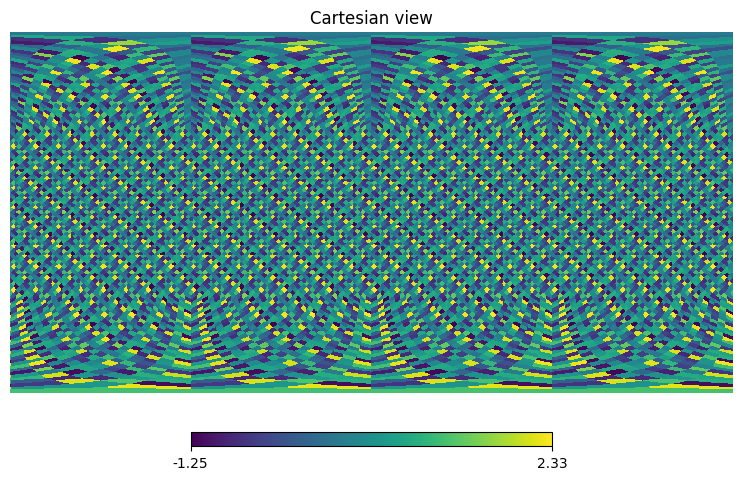

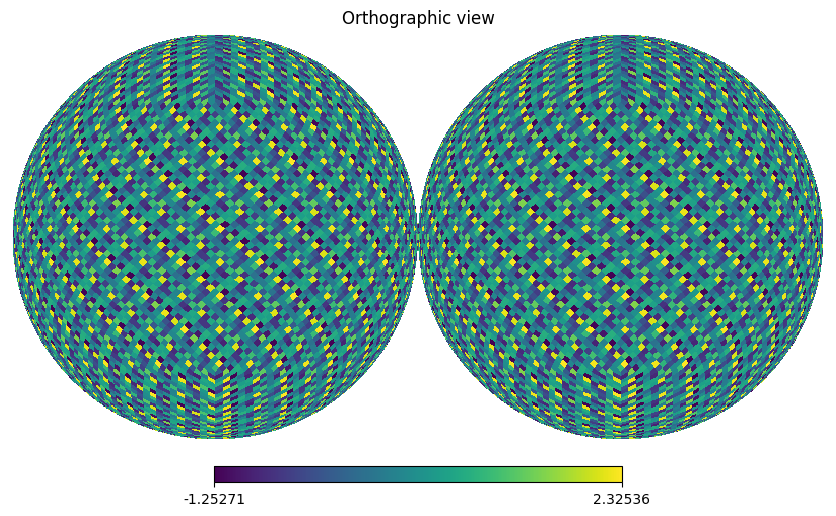

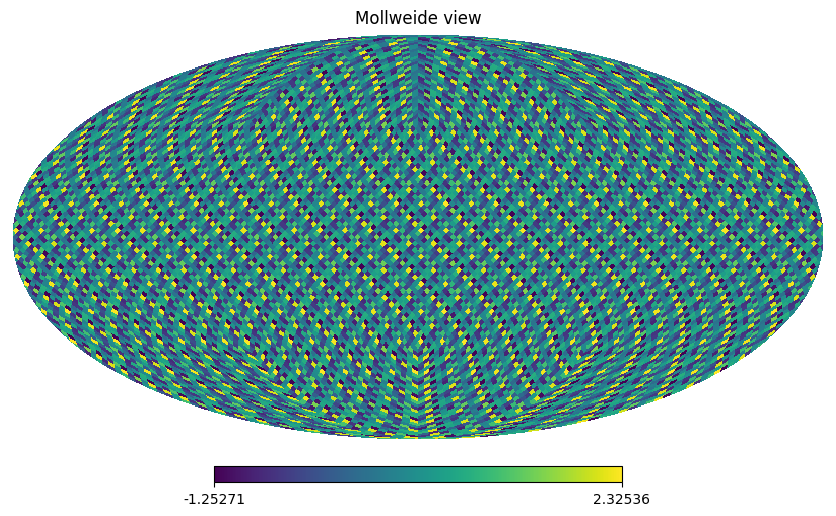

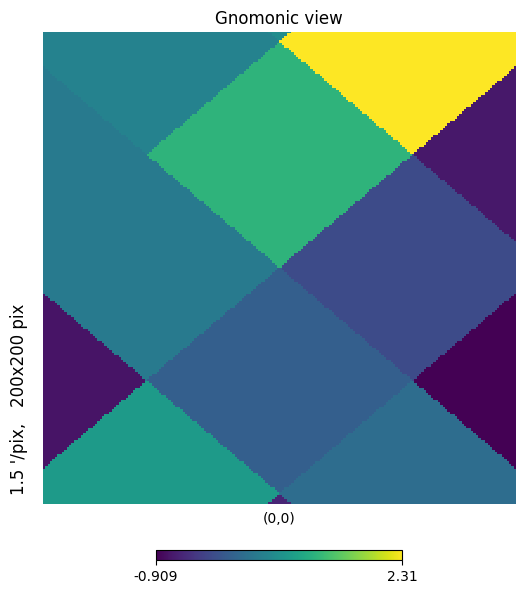

In [30]:
output = out["logits_surface"]
output = output.squeeze().T
cpu_output = output.cpu()
co2, so2, ch4, bc = cpu_output

#healpix_plotting(np.array(co2))
healpix_plotting(np.array(so2))

/tmp/ipykernel_3679788/241358000.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  healpix_plotting(np.array(co2))
/tmp/ipykernel_3679788/241358000.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  healpix_plotting(np.array(ch4))
/tmp/ipykernel_3679788/241358000.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration gui

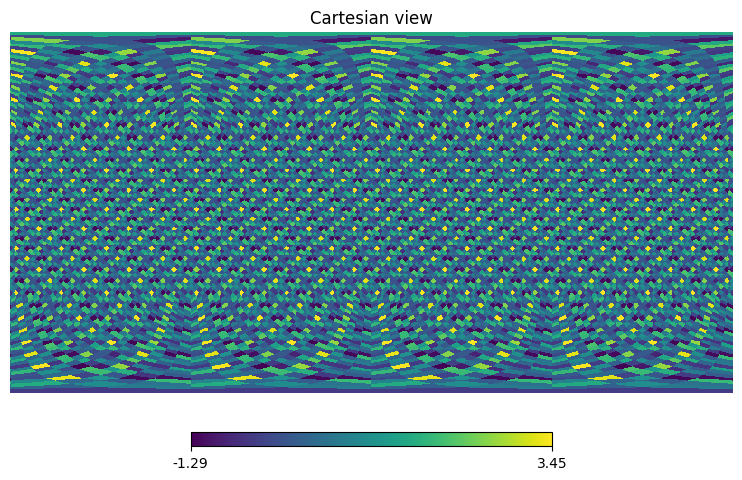

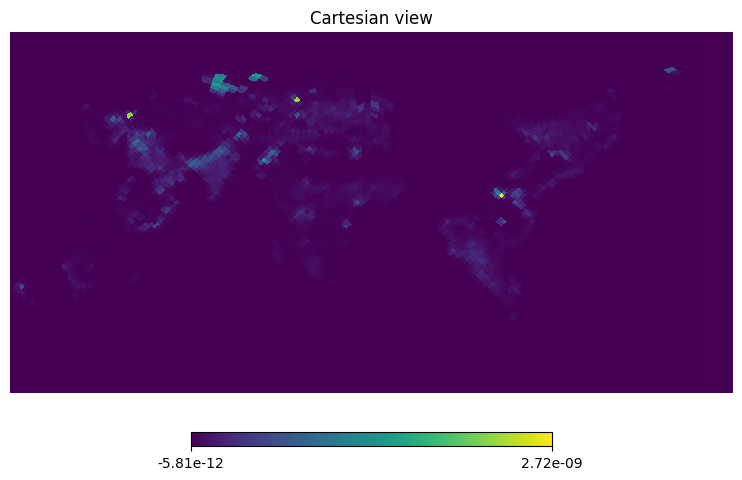

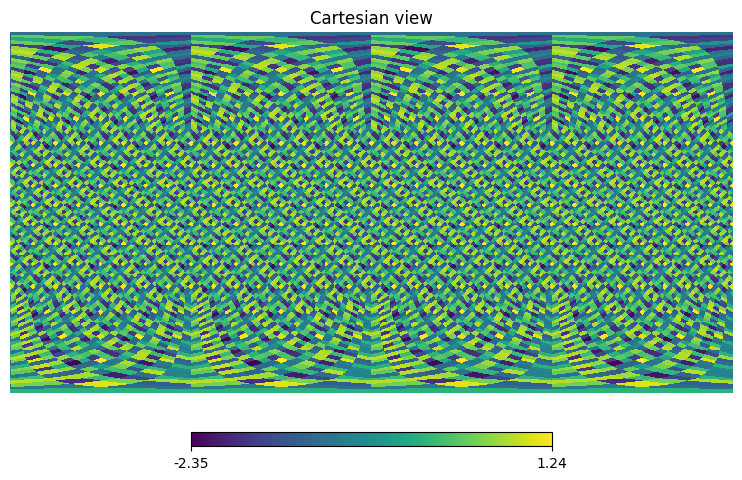

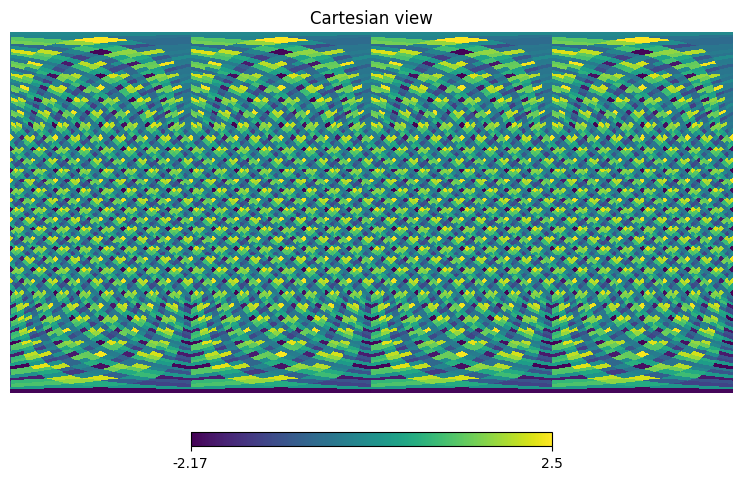

In [33]:
output = out["logits_surface"]
output = output.squeeze().T
cpu_output = output.cpu()
co2, so2, ch4, bc = cpu_output

healpix_plotting(np.array(co2))
healpix_plotting(np.array(input_test_array2[1]))
healpix_plotting(np.array(ch4))
healpix_plotting(np.array(bc))

### Overfit single sample test

In [11]:
import torch
import numpy as np
from experiments.climate.models.swin_hp_climateset import SwinHPPanguPadSurfaceOnly

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- model ----
model = SwinHPPanguPadSurfaceOnly(model_config, data_spec).to(device)
model.train()  # IMPORTANT

# ---- single sample ----
# Original numpy shape: (4, 49152) or (49152, 4)
x_sample = np.array([BC_hp, CH4_hp, SO2_hp, CO2_hp])   # (4, N)
x_sample = torch.from_numpy(x_sample).float().unsqueeze(0).to(device)
# shape: (B=1, C=4, N)

eps = 1e-12  # numerical stability

x_log = torch.log10(x_sample.clamp(min=1e-15) + 1e-15)
mean = x_log.mean()
std = x_log.std().clamp(min=eps)  # avoid division by zero
x_scaled = (x_log - mean) / std

print(x_scaled.min())
print(x_scaled.max())
# ---- optimizer & loss ----
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# ---- overfit loop ----
n_steps = 5000

for step in range(n_steps):
    optimizer.zero_grad()

    out = model({"input_surface": x_scaled})
    #y_pred = out["logits_surface"]        # (B, C, N)
    y_pred = out["logits_surface"].permute(0, 2, 1)
    y_true = x_scaled                     # identity target

    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"step {step:04d} | loss = {loss.item():.6e}")

print("done")


tensor(-1.1705, device='cuda:0')
tensor(3.3528, device='cuda:0')
step 0000 | loss = 3.021918e+00
step 0050 | loss = 1.215599e-01
step 0100 | loss = 8.284643e-02
step 0150 | loss = 6.488639e-02
step 0200 | loss = 5.252775e-02
step 0250 | loss = 4.388364e-02
step 0300 | loss = 3.760903e-02
step 0350 | loss = 3.294149e-02
step 0400 | loss = 2.951093e-02
step 0450 | loss = 2.660330e-02
step 0500 | loss = 2.514586e-02
step 0550 | loss = 2.504945e-02
step 0600 | loss = 1.993984e-02
step 0650 | loss = 1.822650e-02
step 0700 | loss = 1.771417e-02
step 0750 | loss = 1.578623e-02
step 0800 | loss = 1.398908e-02
step 0850 | loss = 1.369613e-02
step 0900 | loss = 1.212287e-02
step 0950 | loss = 1.493791e-02
step 1000 | loss = 1.083394e-02
step 1050 | loss = 1.090865e-02
step 1100 | loss = 9.661272e-03
step 1150 | loss = 1.327430e-02
step 1200 | loss = 9.118631e-03
step 1250 | loss = 8.167669e-03
step 1300 | loss = 8.098162e-03
step 1350 | loss = 7.815681e-03
step 1400 | loss = 7.342424e-03
step 14

tensor([[-0.2278, -0.0152,  0.1597,  ...,  0.0956,  0.1291, -0.1901],
        [ 0.7499,  0.9647,  1.1704,  ...,  1.0541,  1.1377,  0.7755],
        [-0.2651, -0.1380, -0.0743,  ...,  0.4182,  0.4184,  0.1598],
        [ 0.9455,  0.9840,  1.1120,  ...,  1.7693,  1.8120,  1.4699]],
       device='cuda:0')


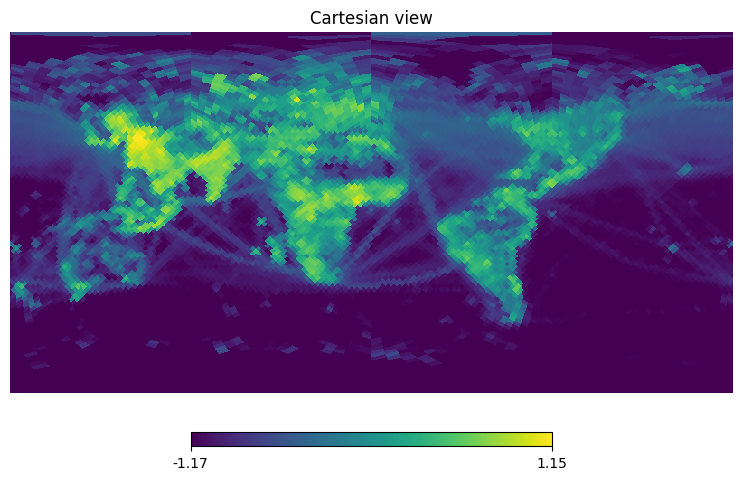

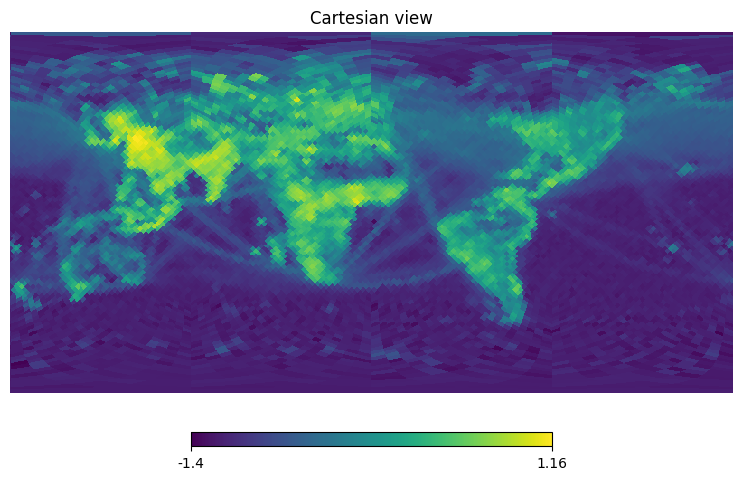

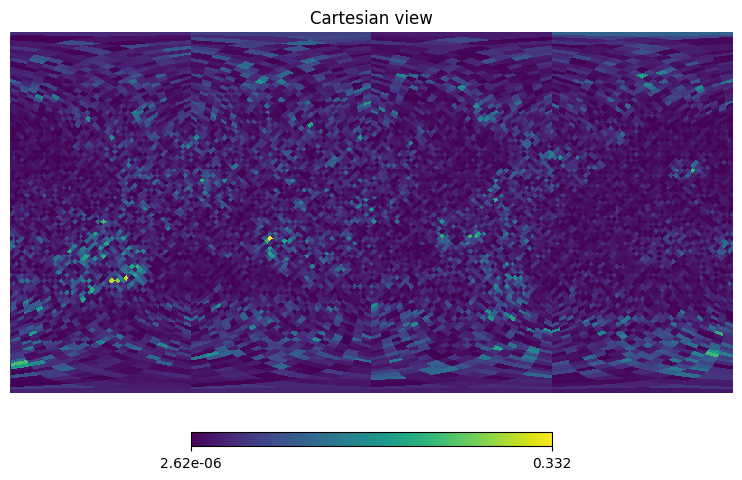

In [16]:
input_v = x_scaled.detach()
input_v = input_v.squeeze()
print(input_v)
cpu_input_v = input_v.cpu()
inp_co2, inp_so2, inp_ch4, inp_bc = cpu_input_v

output = out["logits_surface"]
output = output.squeeze().T
cpu_output = output.cpu()
co2, so2, ch4, bc = cpu_output

#healpix_plotting(np.array(co2))
healpix_plotting(inp_co2.numpy())
healpix_plotting(co2.detach().numpy())

diff = inp_co2.numpy() - co2.detach().numpy()
healpix_plotting(np.abs(diff))

In [ ]:
import time
import copy
import json
import torch
import numpy as np
import math
from pathlib import Path
from datetime import datetime, timedelta
import shutil
from multiprocessing import Pool


# from lib.models.healpix.swin_hp_transformer import SwinHPTransformerConfig

# from lib.models.mlp import MLPConfig
from lib.serialize_human import serialize_human
from lib.compute_env import env

from dataclasses import dataclass
import healpix
import chealpix
import xarray as xr
import experiments.weather.cdsmontly as cdstest
import experiments.weather.masks.masks as masks


def numpy_to_xds(np_array, xds_template):
    transformed_ds = xr.Dataset()
    for i, var_name in enumerate(xds_template.data_vars):
        transformed_ds[var_name] = xr.DataArray(
            np_array[i], dims=xds_template.dims, coords=xds_template.coords
        )
    return transformed_ds


ERA5_START_YEAR_TRAINING = 2007
ERA5_END_YEAR_TRAINING = 2017
ERA5_START_YEAR_TEST = 2019
ERA5_END_YEAR_TEST = 2019


@dataclass
class DataHPConfig:
    nside: int = 64
    version: int = 10
    driscoll_healy: bool = False
     # cache: bool = True
    normalized: bool = True
    # start_year: int = 2007
    # end_year: int = 2017
    lead_time_days: int = 1

    def short_name(self):
        return f"era5_{self.start_year}_{self.end_year}"

    def serialize_human(self):
        return serialize_human(self.__dict__)

    def custom_dict(self):
        serialize_dict = copy.deepcopy(self.__dict__)
        if self.start_year == 2007 and self.end_year == 2017:
            del serialize_dict["start_year"]
            del serialize_dict["end_year"]
        del serialize_dict["lead_time_days"]
        return serialize_dict

    def statistics_name(self):
        keys = sorted(self.__dict__.keys())
        keys.remove("cache")
        keys.remove("normalized")
        keys.remove("lead_time_days")
        keys.remove("end_year")
        return "_".join([f"{key}_{self.__dict__[key]}" for key in keys])

    def cache_name(self):
        keys = sorted(self.__dict__.keys())
        keys.remove("cache")
        keys.remove("lead_time_days")
        keys.remove("end_year")
        return "_".join([f"{key}_{self.__dict__[key]}" for key in keys])

    def validation(self):
        ret = copy.deepcopy(self)
        ret.start_year = ERA5_START_YEAR_TEST
        ret.end_year = ERA5_END_YEAR_TEST
        return ret

    def as_hp(self):
        ret = copy.deepcopy(self)
        ret.driscoll_healy = False
        return ret

    def with_lead_time_days(self, days: int):
        ret = copy.deepcopy(self)
        ret.lead_time_days = days
        return ret


@dataclass
class DataSpecHP:
    nside: int
    n_surface: int
    n_upper: int


def days_between_years(start_year: int, end_year: int) -> int:
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    return (end_date - start_date).days


def days_from_start_year(start_year: int, year: int, month: int, day: int) -> int:
    start_date = datetime(start_year, 1, 1)  # Start of the start year
    specific_date = datetime(year, month, day)  # Specific date
    return (specific_date - start_date).days


def day_index_to_datetime(day_index: int, start_year: int, end_year: int):
    start_date = datetime(start_year, 1, 1)
    target_date = start_date + timedelta(days=day_index)
    return target_date


def day_index_to_era5_config(
    day_index: int, start_year: int, end_year: int
) -> cdstest.ERA5SampleConfig:
    target_date = day_index_to_datetime(day_index, start_year, end_year)
    return cdstest.ERA5SampleConfig(
        year=target_date.strftime("%Y"),
        month=target_date.strftime("%m"),
        day=target_date.strftime("%d"),
        time="00:00:00",
    )


def day_index_to_climatology_indices(day_index, start_year, end_year):
    day_config = day_index_to_era5_config(day_index, start_year, end_year)
    indices = []
    for year in range(start_year, end_year + 1):
        indices.append(
            days_from_start_year(
                start_year, year, int(day_config.month), int(day_config.day)
            )
        )
    return indices


class Climatology(torch.utils.data.Dataset):
    def __init__(self, data_config: DataHPConfig):
        self.ds = DataHP(data_config)
        climate_config = copy.deepcopy(data_config)
        climate_config.start_year = ERA5_START_YEAR_TRAINING
        climate_config.end_year = ERA5_END_YEAR_TRAINING
        self.ds_climate = DataHP(climate_config)
        self.climate_config = climate_config
        self.config = data_config

    def get_meta(self):
        return self.ds.get_meta()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        cache_path = self.ds_climate.get_cache_dir() / "climate"
        climate_indices = day_index_to_climatology_indices(
            index, self.climate_config.start_year, self.climate_config.end_year
        )
        indices_str = "_".join(map(str, climate_indices))
        fs_cache_path = cache_path / f"{indices_str}"
        fs_cache_path_tmp = cache_path / f"{indices_str}_constructing"
        names = dict(
            climate_target_surface="climate_target_surface.npy",
            climate_target_upper="climate_target_upper.npy",
        )
        item_dict = dict(
            sample_id=index,
        )
        if fs_cache_path.is_dir() and self.config.cache:
            print("Climate cache")
            item_dict.update(self.ds[index])
            for key, filename in names.items():
                item_dict[key] = np.load(fs_cache_path / filename).astype(np.float32)
        else:
            print("Climate hydrating cache")
            accum_dict = dict()
            for cidx in climate_indices:
                data_dict = self.ds_climate[cidx]
                keys = ["target_surface", "target_upper"]
                for key in keys:
                    if key not in accum_dict:
                        accum_dict[key] = data_dict[key].astype(np.float64)
                    else:
                        accum_dict[key] += data_dict[key].astype(np.float64)
            for key in accum_dict.keys():
                accum_dict[key] /= len(climate_indices)

            item_dict.update(self.ds[index])
            item_dict["climate_target_surface"] = accum_dict["target_surface"]
            item_dict["climate_target_upper"] = accum_dict["target_upper"]
            if self.config.cache:
                fs_cache_path_tmp.mkdir(parents=True, exist_ok=True)
                for key, filename in names.items():
                    np.save(fs_cache_path_tmp / filename, item_dict[key])

                if not fs_cache_path.is_dir():
                    shutil.move(fs_cache_path_tmp, fs_cache_path)

        return item_dict


def interpolate_dh_to_hp(nside, variable: xr.DataArray):
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(latitude=xlat, longitude=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_array().to_numpy(), dtype=np.float32)
    return hp_image


def e5_to_numpy_hp(e5xr, nside: int, normalized: bool):

    hp_surface = interpolate_dh_to_hp(nside, e5xr.surface)
    hp_upper = interpolate_dh_to_hp(nside, e5xr.upper)

    if normalized:
        stats = deserialize_dataset_statistics(nside)
        hp_surface, hp_upper = normalize_sample(stats.item(), hp_surface, hp_upper)

    return hp_surface, hp_upper


def batch_to_weatherbench2(
    input_batch, output_batch, nside: int, normalized: bool, lead_days: int = 1
):
    xds = numpy_hp_to_e5(
        output_batch["logits_surface"],
        output_batch["logits_upper"],
        times=input_batch["time"],
        nside=nside,
        normalized=normalized,
        lead_days=lead_days,
    )
    return xds


def numpy_hp_to_e5(
    hp_surface, hp_upper, times, nside: int, normalized: bool, lead_days: int = 1
):
    if torch.isnan(hp_surface).any():
        print("NaNs!")
    if torch.isnan(hp_upper).any():
        print("NaNs!")

    if normalized:
        stats = deserialize_dataset_statistics(nside)
        hp_surface, hp_upper = denormalize_sample(stats.item(), hp_surface, hp_upper)

    def regrid_to_original(hp_data, dims):
        xhp = xr.DataArray(hp_data, dims=dims)
        lat = np.linspace(-90.0, 90.0, 721, endpoint=True)
        lon = np.linspace(0.0, 360.0, 1440, endpoint=False)
        lat2, lon2 = np.meshgrid(lat, lon, indexing="ij")
        idxs = healpix.ang2pix(nside, lon2, lat2, nest=False, lonlat=True)
        idxs = chealpix.ring2nest(nside, idxs)
        idxhp = xr.DataArray(
            idxs,
            dims=["latitude", "longitude"],
            coords={"latitude": lat, "longitude": lon},
        )
        return xhp.interp(z=idxhp, kwargs={"fill_value": "extrapolate"})

    surface = regrid_to_original(
        np.expand_dims(hp_surface, 1),
        dims=("time", "prediction_timedelta", "variable", "z"),
    )
    upper = regrid_to_original(
        np.expand_dims(hp_upper, 1),
        dims=("time", "prediction_timedelta", "variable", "level", "z"),
    )

    if surface.isnull().any():
        print("surface NaN after regrid")
    if upper.isnull().any():
        print("upper NaN after regrid")

    surface = surface.assign_coords(
        {
            "time": [np.datetime64(t) for t in times],
            "prediction_timedelta": [np.timedelta64(timedelta(days=lead_days))],
        }
    )
    upper = upper.assign_coords(
        {
            "time": [np.datetime64(t) for t in times],
            "prediction_timedelta": [np.timedelta64(timedelta(days=lead_days))],
            "level": np.array(
                [
                    1000,
                    925,
                    850,
                    700,
                    600,
                    500,
                    400,
                    300,
                    250,
                    200,
                    150,
                    100,
                    50,
                ],
                dtype=np.int32,
            ),
        }
    )

    surface_ds = surface.to_dataset("variable").rename_vars(
        {
            0: "mean_sea_level_pressure",
            1: "10m_u_component_of_wind",
            2: "10m_v_component_of_wind",
            3: "2m_temperature",
        }
    )
    upper_ds = upper.to_dataset("variable").rename_vars(
        {
            0: "geopotential",
            1: "specific_humidity",
            2: "temperature",
            3: "u_component_of_wind",
            4: "v_component_of_wind",
        }
    )
    # e5xr = xr.Dataset({"surface": surface, "upper": upper})
    # Identify misaligned coordinates

    final = xr.merge(
        [surface_ds.drop_vars("z"), upper_ds.drop_vars("z")],
    )  # surface, upper

    return final


class DataHP(torch.utils.data.Dataset):
    def __init__(self, data_config: DataHPConfig):
        self.config = data_config
        # self.masks = masks.load_mask_hp(data_config.nside)

    @staticmethod
    def data_spec(config: DataHPConfig):
        return DataSpecHP(nside=config.nside, n_surface=4, n_upper=5)

    def e5_to_numpy(self, e5xr):
        if self.config.driscoll_healy:
            return self.e5_to_numpy_dh(e5xr)
        else:
            return e5_to_numpy_hp(e5xr, self.config.nside, self.config.normalized)

    def dh_resolution(self):
        n_pixels = healpix.nside2npix(self.config.nside)
        # np_dh = w * h / 2^(2n)
        # 2^(2n) = w * h / np_dh
        # 2n = log2(w*h/np_dh)
        # n = log2(w*h/np_dh) / 2
        scale_factor = math.log2(1440 * 721 / n_pixels) / 2
        lon = math.ceil(1440 / 2**scale_factor)
        lat = math.ceil(721 / 2**scale_factor)
        return dict(lat=lat, lon=lon)

    def e5_to_numpy_dh(self, e5xr):
        n_pixels = healpix.nside2npix(self.config.nside)
        # np_dh = w * h / 2^(2n)
        # 2^(2n) = w * h / np_dh
        # 2n = log2(w*h/np_dh)
        # n = log2(w*h/np_dh) / 2
        scale_factor = math.log2(1440 * 721 / n_pixels) / 2
        lon = math.ceil(1440 / 2**scale_factor)
        lat = math.ceil(721 / 2**scale_factor)

        new_lon = np.linspace(
            e5xr.surface.longitude[0], e5xr.surface.longitude[-1], lon
        )
        new_lat = np.linspace(e5xr.surface.latitude[0], e5xr.surface.latitude[-1], lat)

        def interpolate(variable: xr.DataArray):
            xhp = variable.interp(
                latitude=new_lat, longitude=new_lon, kwargs={"fill_value": None}
            )
            np_image = np.array(xhp.to_array().to_numpy(), dtype=np.float32)
            return np_image

        dh_surface = interpolate(e5xr.surface)
        dh_upper = interpolate(e5xr.upper)
        if self.config.normalized:
            stats = deserialize_dataset_statistics(self.config.nside)
            dh_surface, dh_upper = normalize_sample(stats.item(), dh_surface, dh_upper)

        return dh_surface, dh_upper

    def get_driscoll_healy(self, idx):
        e5sc = cdstest.ERA5SampleConfig(
            year="1999", month="01", day="01", time="00:00:00"
        )
        e5s = cdstest.get_era5_sample(e5sc)
        e5_target_config = cdstest.ERA5SampleConfig(
            year="1999", month="01", day="01", time="03:00:00"
        )
        e5target = cdstest.get_era5_sample(e5_target_config)
        return e5s, e5target

    def get_template_e5s(self):
        e5sc = cdstest.ERA5SampleConfig(
            year="2007", month="01", day="01", time="00:00:00"
        )
        e5s = cdstest.get_era5_sample(e5sc)
        return e5s

    def get_meta(self):
        temp = self.get_template_e5s()

        def get_metas(variable):
            names = [str(var) for var in variable.data_vars.variables]
            long_names = [
                variable.data_vars.variables[var].attrs["long_name"] for var in names
            ]
            units = [variable.data_vars.variables[var].attrs["units"] for var in names]
            return dict(
                names=names,
                long_names=long_names,
                units=units,
            )

        surface_metas = get_metas(temp.surface)
        upper_metas = get_metas(temp.upper)

        return dict(surface=surface_metas, upper=upper_metas)

    def get_cache_dir(self):
        return env().paths.datasets / self.config.cache_name()

    def get_statistics_path(self):
        return env().paths.datasets / f"{self.config.statistics_name()}.npy"

    def get_old_cache_dir(self):
        if self.config.driscoll_healy:
            return (
                env().paths.datasets
                / f"era5_lite_np_cache_normalized_{self.config.normalized}_nside_{self.config.nside}_dh"
            )
        else:
            return (
                env().paths.datasets
                / f"era5_lite_np_cache_normalized_{self.config.normalized}_nside_{self.config.nside}"
            )

    def __getitem__(self, idx):
        if self.config.lead_time_days == 1:
            return self._get_24h(idx)
        else:
            sample = self._get_24h(idx)
            target = self._get_24h(idx + self.config.lead_time_days - 1)
            sample["target_surface"] = target["target_surface"]
            sample["target_upper"] = target["target_upper"]
            sample["prediction_timedelta_hours"] = 24 * self.config.lead_time_days
            return sample

    def _get_24h(self, idx):
        if idx >= len(self):
            raise StopIteration()
        fs_cache_path = self.get_cache_dir() / f"{idx}"
        fs_cache_path_tmp = self.get_cache_dir() / f"{idx}_constructing"
        names = dict(
            input_surface="surface.npy",
            input_upper="upper.npy",
            target_surface="target_surface.npy",
            target_upper="target_upper.npy",
        )
        item_dict = dict(
            sample_id=idx,
            time=np.datetime_as_string(
                np.datetime64(
                    day_index_to_datetime(
                        idx, self.config.start_year, self.config.end_year
                    )
                )
            ),
            prediction_timedelta_hours=24,
        )
        done = False
        while not done:
            try:
                fs_cache_path.is_dir()
                done = True
            except OSError:
                time.sleep(0.5)

        if fs_cache_path.is_dir() and self.config.cache:
            # print("Loading from cache")
            for key, filename in names.items():
                item_dict[key] = np.load(fs_cache_path / filename).astype(np.float32)
        else:
            e5s_input_config = day_index_to_era5_config(
                idx, self.config.start_year, self.config.end_year
            )
            e5s_target_config = cdstest.add_timedelta(e5s_input_config, days=1)
            # print("Get ERA5 sample")
            e5s = cdstest.get_era5_sample(e5s_input_config)
            e5target = cdstest.get_era5_sample(e5s_target_config)
            # print("Get ERA5 sample done")
            hp_surface, hp_upper = self.e5_to_numpy(e5s)
            hp_target_surface, hp_target_upper = self.e5_to_numpy(e5target)
            # print("To numpy done")
            data_dict = dict(
                input_surface=hp_surface.astype(np.float32),
                input_upper=hp_upper.astype(np.float32),
                target_surface=hp_target_surface.astype(np.float32),
                target_upper=hp_target_upper.astype(np.float32),
            )
            if self.config.cache:
                fs_cache_path_tmp.mkdir(parents=True, exist_ok=True)
                for key, filename in names.items():
                    np.save(fs_cache_path_tmp / filename, data_dict[key])

                open(fs_cache_path_tmp / "era5config_input.json", "w").write(
                    json.dumps(e5s_input_config.__dict__, indent=2)
                )
                open(fs_cache_path_tmp / "era5config_target.json", "w").write(
                    json.dumps(e5s_target_config.__dict__, indent=2)
                )

                if not fs_cache_path.is_dir():
                    shutil.move(fs_cache_path_tmp, fs_cache_path)
            # print("Write done")

            item_dict.update(data_dict)

        item_dict["masks"] = masks.load_mask_hp(self.config.nside)

        return item_dict

    def __len__(self):
        return days_between_years(self.config.start_year, self.config.end_year)


def deserialize_dataset_statistics(nside):
    ds = DataHP(DataHPConfig(nside=nside))
    return np.load(ds.get_statistics_path(), allow_pickle=True)


def _fix_dataset_statistics(nside):
    stats = deserialize_dataset_statistics(nside).item()
    std_surface = np.sqrt(
        stats["mean_x2_surface"].astype(np.float64)
        - (stats["mean_surface"].astype(np.float64)) ** 2
    ).astype(np.float32)
    std_upper = np.sqrt(
        stats["mean_x2_upper"].astype(np.float64)
        - (stats["mean_upper"].astype(np.float64)) ** 2
    ).astype(np.float32)
    statistics_dict = dict(
        mean_surface=stats["mean_surface"],
        mean_upper=stats["mean_upper"],
        mean_x2_surface=stats["mean_x2_surface"],
        mean_x2_upper=stats["mean_x2_upper"],
        std_surface=std_surface,
        std_upper=std_upper,
        n_samples=stats["n_samples"],
    )
    print(statistics_dict)
    # np.save(ds.get_cache_dir() / "statistics.npy", statistics_dict)


def normalize_sample(stats, surface, upper):
    if len(stats["mean_surface"].shape) == len(surface.shape):
        norm_surface = (surface - stats["mean_surface"]) / stats["std_surface"]
        norm_upper = (upper - stats["mean_upper"]) / stats["std_upper"]
    else:
        norm_surface = (surface - stats["mean_surface"][..., None]) / stats[
            "std_surface"
        ][..., None]
        norm_upper = (upper - stats["mean_upper"][..., None]) / stats["std_upper"][
            ..., None
        ]
    return norm_surface, norm_upper


def denormalize_sample(stats, surface, upper):
    if len(stats["mean_surface"].shape) == len(surface.shape[1:]):
        denorm_surface = surface * stats["std_surface"] + stats["mean_surface"]
        denorm_upper = upper * stats["std_upper"] + stats["mean_upper"]
    else:
        denorm_surface = (
            surface * stats["std_surface"][..., None] + stats["mean_surface"][..., None]
        )
        denorm_upper = (
            upper * stats["std_upper"][..., None] + stats["mean_upper"][..., None]
        )
    return denorm_surface, denorm_upper


def _get_stats_at_idx(idx_and_nside_tuple):
    idx, nside = idx_and_nside_tuple
    ds = DataHP(DataHPConfig(nside=nside, cache=False, normalized=False))
    sample = ds[idx]
    mean_surface = (
        sample["input_surface"].astype(np.float64).mean(axis=1, keepdims=True)
    )
    mean_upper = sample["input_upper"].astype(np.float64).mean(axis=2, keepdims=True)
    mean_x2_surface = (sample["input_surface"].astype(np.float64) ** 2).mean(
        axis=1, keepdims=True
    )
    mean_x2_upper = (sample["input_upper"].astype(np.float64) ** 2).mean(
        axis=2, keepdims=True
    )
    return mean_surface, mean_upper, mean_x2_surface, mean_x2_upper


def serialize_dataset_statistics(nside, test_with_one_sample=False):
    ds = DataHP(DataHPConfig(nside=nside, cache=False, normalized=False))

    if test_with_one_sample:
        n_samples = 1
        n_samples_left = 1
    else:
        n_samples = len(ds)
        n_samples_left = len(ds)

    sample = ds[0]
    mean_surface = np.zeros_like(
        sample["input_surface"].mean(axis=1, keepdims=True), dtype=np.float64
    )
    mean_upper = np.zeros_like(
        sample["input_upper"].mean(axis=2, keepdims=True), dtype=np.float64
    )
    mean_x2_surface = np.zeros_like(mean_surface)
    mean_x2_upper = np.zeros_like(mean_upper)

    import os
    import time

    batch_size = int(os.getenv("SLURM_CPUS_ON_NODE", f"{os.cpu_count()}"))
    print(f"Starting with batch size {batch_size}")
    idx = 0

    # n_samples_left = 34

    with Pool(batch_size) as p:
        while n_samples_left > 0:
            n_requests = min(batch_size, n_samples_left)
            chunks = zip(range(idx, idx + n_requests), [nside] * n_requests)
            start_time = time.time()
            res = p.map(_get_stats_at_idx, chunks)
            idx += n_requests
            n_samples_left -= n_requests
            for (
                sample_mean_surface,
                sample_mean_upper,
                sample_mean_x2_surface,
                sample_mean_x2_upper,
            ) in res:
                mean_surface += sample_mean_surface
                mean_upper += sample_mean_upper
                mean_x2_surface += sample_mean_x2_surface
                mean_x2_upper += sample_mean_x2_upper

            print(
                f"{n_requests} samples in {(time.time() - start_time):.02f}s, {n_samples_left} left"
            )

    mean_surface = mean_surface / n_samples
    mean_upper = mean_upper / n_samples
    mean_x2_surface = mean_x2_surface / n_samples
    mean_x2_upper = mean_x2_upper / n_samples

    std_surface = np.sqrt(mean_x2_surface - (mean_surface) ** 2)
    std_upper = np.sqrt(mean_x2_upper - (mean_upper) ** 2)
    statistics_dict = dict(
        mean_surface=mean_surface,
        mean_upper=mean_upper,
        mean_x2_surface=mean_x2_surface,
        mean_x2_upper=mean_x2_upper,
        std_surface=std_surface,
        std_upper=std_upper,
        n_samples=n_samples,
    )
    ds.get_cache_dir().mkdir(parents=True, exist_ok=True)
    np.save(ds.get_statistics_path(), statistics_dict)
    print(f"Saved npy {ds.get_statistics_path()}")


In [ ]:
# taken from persisted config files
def create_config(ensemble_id, epoch=200, dataset_years=10):
    loss = torch.nn.L1Loss()

    def reg_loss(output, batch):
        # breakpoint()
        # breakpoint()
        # return loss(output["logits_upper"], batch["target_upper"])  # + 0.25 * loss(

        return loss(output["logits_upper"], batch["target_upper"]) + 0.25 * loss(
            output["logits_surface"], batch["target_surface"]
        )
        # return loss(output["logits_surface"], batch["target_surface"])

    train_config = TrainConfig(
        extra=dict(loss_variant="full"),
        model_config=SwinHPPanguPadConfig(
            base_pix=12,
            nside=NSIDE,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[2, 64],  # int(32 * (NSIDE / 256)),
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        ),
        train_data_config=DataHPConfig(nside=NSIDE, end_year=2007 + dataset_years),
        val_data_config=None,  # DataHPConfig(nside=NSIDE),
        loss=reg_loss,
        optimizer=OptimizerConfig(
            optimizer=torch.optim.AdamW,
            kwargs=dict(weight_decay=3e-6, lr=5e-4),
            # kwargs=dict(weight_decay=3e-6, lr=5e-3),
        ),
        batch_size=1,
        ensemble_id=ensemble_id,
        # gradient_clipping=0.3,
        # _version=57,
        # NOTE: Versions below 13 used buggy window shifting
        _version=17,
        # _version=55,
    )
    train_eval = TrainEval(
        train_metrics=[create_metric(reg_loss)],
        validation_metrics=[],
        log_gradient_norm=True,
    )  # create_regression_metrics(torch.nn.functional.l1_loss, None)
    train_run = TrainRun(
        project="weather",
        # compute_config=ComputeConfig(distributed=False, num_workers=0, num_gpus=1),
        # compute_config=ComputeConfig(distributed=False, num_workers=5, num_gpus=1),
        # compute_config=ComputeConfig(distributed=True, num_workers=5, num_gpus=4),
        compute_config=ComputeConfig(),
        train_config=train_config,
        train_eval=train_eval,
        epochs=epoch,
        save_nth_epoch=1,
        keep_epoch_checkpoints=True,
        keep_nth_epoch_checkpoints=10,
        validate_nth_epoch=20,
        visualize_terminal=False,
        notes=dict(shift="fixed: ring shift uses shift_size instead of window/2"),
    )
    return train_run

In [ ]:
ensemble_config = create_ensemble_config(
    lambda eid: create_config(eid, dataset_years=dataset_years), 1
)
request_ensemble(ensemble_config)
distributed_train(ensemble_config.members)

## Load multiple samples

In [4]:
import healpix
def interpolate_dh_to_hp(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(lat=xlat, lon=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image

def interpolate_dh_to_hp_output(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(y=xlat, x=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image

def e5_to_numpy_hp(e5xr, nside: int, normalized: bool):
    """
    Input is class with xr.DataArray class variables
    """

    hp_surface = interpolate_dh_to_hp(nside, e5xr.surface)
    hp_upper = interpolate_dh_to_hp(nside, e5xr.upper)

    if normalized:
        stats = deserialize_dataset_statistics(nside)
        hp_surface, hp_upper = normalize_sample(stats.item(), hp_surface, hp_upper)

    return hp_surface, hp_upper

def get_input_paths(exp, input_dir, fire_type):
    input_gasses = {
    "BC":  "BC_sum",
    "CH4": "CH4_sum",
    "SO2": "SO2_sum",
    "CO2": "CO2_sum",
    }
    gas_files = {g: [] for g in gas_patterns}
    for gas, folder_name in input_gasses.items():
        var_dir = os.path.join(input_dir, exp, folder_name, "250_km", "mon")
        files = glob.glob(var_dir + "/**/*.nc", recursive=True)
    
        for f in files:
            if folder_name in f and (gas == "CO2" or fire_type in f): # CO2 does not have fire_type
                gas_files[gas].append(f)
    #print(gas_files["BC"])
    # Check same len
    for k, v in gas_files.items():
        print(k, len(v))

    return gas_files

def get_output_paths(exp, target_dir, mod, ensembles, variables):
    var_file_dict = {v: [] for v in variables}
    for var in variables:
        var_dir = os.path.join(target_dir, mod, ensembles, exp, var, '250_km', 'mon')
        var_files = glob.glob(var_dir + '/**/*.nc', recursive=True)
        #var_file_dict[var].append(var_files)
        for f in var_files:
            var_file_dict[var].append(f)

    return var_file_dict

def get_hp_dataset(files : dict, nside : int, output : bool = False):
    hp_gas_dict = {}
    #print(files)
    for var, var_files in files.items():

        
        # ds = xr.open_mfdataset(var_files, concat_dim="time", combine="nested")
        # this required dask, which is not currently in constructed apptainer

        datasets = [xr.open_dataset(f) for f in var_files]
        ds = xr.concat(datasets, dim="time").sortby("time")
        
        ds = ds.sortby("time")
        arr = ds.to_array().squeeze("variable") # remove var dim since 1

        if output:
            hp = interpolate_dh_to_hp_output(nside, arr)
        else:
            hp = interpolate_dh_to_hp(nside, arr)
        # print(type(hp))
        hp_gas_dict[var] = hp

    return hp_gas_dict

import healpy
def healpix_plotting(hp_data, data_shift=0, norm=None, nest=True):
    data = hp_data + data_shift
    healpy.visufunc.cartview(data, nest=nest, norm=norm)
    #healpy.visufunc.orthview(data, nest=nest, norm=norm)
    #healpy.visufunc.mollview(data, nest=nest, norm=norm)
    #healpy.visufunc.gnomview(data, nest=nest, norm=norm)

In [5]:
datapath = "/proj/heal_pangu/users/x_tagty/climateset"
input_dir = os.path.join(datapath, "inputs", "input4mips")
target_dir = os.path.join(datapath, "outputs", "CMIP6")

fire_type = 'all-fires'
variables = ['tas']

mod = 'CAS-ESM2-0'
ensembles = 'r3i1p1f1'
experiments = ["ssp585", "ssp126", "ssp370"]
#experiments = [train_experiments[0]]
#input_gases = ['BC_sum', 'CH4_sum', 'CO2_sum', 'SO2_sum']
gas_patterns = {
    "BC":  "BC_sum",
    "CH4": "CH4_sum",
    "SO2": "SO2_sum",
    "CO2": "CO2_sum",
}

nside = 32
experiment_input_dict = {}
experiment_output_dict = {}
for exp in experiments:
    input_paths = get_input_paths(exp, input_dir, fire_type)
    print("got input paths")
    hp_input_dict = get_hp_dataset(input_paths, nside)
    print("hp input done")
    # TODO : Add concatenate or similar if multiple experiments
    experiment_input_dict[exp] = hp_input_dict
    
    print("checking outputs")
    output_paths = get_output_paths(exp, target_dir, mod, ensembles, variables)
    print("got output paths")
    hp_target_dict = get_hp_dataset(output_paths, nside, output=True)
    # TODO : Add concatenate or similar  if multiple experiments
    experiment_output_dict[exp] = hp_target_dict

BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths
BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths
BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths


## Create manual batches

In [6]:
def prepare_manual_batches(experiment_input_dict, experiment_output_dict, 
                           gas_vars=['BC', 'CH4', 'SO2', 'CO2'],
                           output_vars=["tas"], # TODO: Add temperature
                           batch_size=8):
    """
    Manually create batches without using DataLoader.
    Returns a list of (input_batch, output_batch) tuples.
    """
    all_inputs = []
    all_outputs = []
    all_metadata = []
    
    # Collect all samples
    for exp in experiment_input_dict.keys():
        n_timesteps = experiment_input_dict[exp][gas_vars[0]].shape[0]
        
        for t in range(n_timesteps):
            # Stack input channels
            input_channels = [experiment_input_dict[exp][var][t] for var in gas_vars]
            input_data = np.stack(input_channels, axis=0)  # (C, N)
            all_inputs.append(input_data)
            
            # Stack output channels (if doing supervised learning)
            if experiment_output_dict and exp in experiment_output_dict:
                output_channels = [experiment_output_dict[exp][var][t] for var in output_vars]
                output_data = np.stack(output_channels, axis=0)
                all_outputs.append(output_data)
            
            all_metadata.append({'exp': exp, 'time': t})
    
    # Convert to numpy arrays
    all_inputs = np.array(all_inputs)  # (N_samples, C, N_pixels)
    if all_outputs:
        all_outputs = np.array(all_outputs)
    
    # Create batches
    n_samples = len(all_inputs)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    batches = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        batch_input = all_inputs[start_idx:end_idx]
        batch_output = all_outputs[start_idx:end_idx] # if all_outputs else None
        batch_meta = all_metadata[start_idx:end_idx]
        
        batches.append({
            'input': batch_input,
            'output': batch_output,
            'metadata': batch_meta,
            'batch_idx': i
        })
    
    return batches, all_inputs, all_outputs


def apply_log_transform(data, global_mean=None, global_std=None, eps=1e-12):
    """Apply log10 transform and normalization"""
    data_log = np.log10(np.clip(data, 1e-15, None) + 1e-15)
    
    if global_mean is not None and global_std is not None:
        data_scaled = (data_log - global_mean) / max(global_std, eps)
    else:
        data_scaled = (data_log - data_log.mean()) / max(data_log.std(), eps)
    
    return data_scaled

In [7]:
input_vars = ['BC', 'CH4', 'SO2', 'CO2']
output_vars = ['tas']
batch_size = 8

# 1. Prepare batches manually
print("Preparing batches...")
batches, all_inputs, all_outputs = prepare_manual_batches(
    experiment_input_dict, 
    experiment_output_dict,
    gas_vars= input_vars,
    output_vars = output_vars,
    batch_size=batch_size
)
print("done")

Preparing batches...
done


In [8]:
# global statistics
all_inputs_log = np.log10(np.clip(all_inputs, 1e-15, None) + 1e-15)
global_mean = all_inputs_log.mean()
global_std = all_inputs_log.std()

In [9]:
test_experiments = ["ssp245"]
test_input_dict = {}
test_output_dict = {}

for exp in test_experiments:
    input_paths = get_input_paths(exp, input_dir, fire_type)
    hp_input_dict = get_hp_dataset(input_paths, nside)
    test_input_dict[exp] = hp_input_dict
    
    output_paths = get_output_paths(exp, target_dir, mod, ensembles, variables)
    hp_target_dict = get_hp_dataset(output_paths, nside, output=True)
    test_output_dict[exp] = hp_target_dict

# Prepare test batches
test_batches, test_inputs, test_outputs = prepare_manual_batches(
    test_input_dict, 
    test_output_dict,
    gas_vars=input_vars,
    output_vars=output_vars,
    batch_size=batch_size
)

BC 86
CH4 86
SO2 86
CO2 86


## Train / Test "Autoencoder" 

In [14]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPPanguPadSurfaceOnly

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)
data_spec = DataSpecHP(nside = nside, n_surface = 4, n_upper = 1)
model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False
data_spec = DataSpecHP(nside=32, n_surface=4, n_upper=1)
model = SwinHPPanguPadSurfaceOnly(model_config, data_spec).to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

# 4. Training loop
n_epochs = 5

print("\nStarting training...")
for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Shuffle batches each epoch (optional)
    if shuffle:
        import random
        random.shuffle(batches)
    
    for batch in batches:
        # Get batch data
        x_batch = batch['input']  # (B, C, N)
        
        # Apply transform
        x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
        
        # Convert to torch and move to device
        x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
        
        # Target (for autoencoding, same as input)
        y_true = x_batch_tensor
        
        # Forward pass
        optimizer.zero_grad()
        out = model({"input_surface": x_batch_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        # Compute loss
        loss = criterion(y_pred, y_true)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Print batch info
        batch_idx = batch['batch_idx']
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Batch {batch_idx}/{len(batches)} | "
                  f"Loss: {loss.item():.6e} | "
                  f"Sample exp: {batch['metadata'][0]['exp']}")
    
    avg_loss = epoch_loss / len(batches)
    print(f"\n==> Epoch {epoch+1} complete | Avg Loss: {avg_loss:.6e}\n")

print("Training complete!")

device:  cuda

Starting training...
Epoch 1/5 | Batch 0/387 | Loss: 2.754329e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 10/387 | Loss: 3.965541e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 20/387 | Loss: 2.245217e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 30/387 | Loss: 1.441237e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 40/387 | Loss: 1.238009e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 50/387 | Loss: 1.151333e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 60/387 | Loss: 1.072214e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 70/387 | Loss: 1.004465e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 80/387 | Loss: 9.555449e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 90/387 | Loss: 8.964151e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 100/387 | Loss: 8.311033e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 110/387 | Loss: 7.838131e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 120/387 | Loss: 7.302244e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 130/387 | Loss: 9.824282e-02 | Sample exp: ssp126
Epoch 1/5 | Batch 140/3

BC 86
CH4 86
SO2 86
CO2 86


### Evaluation

tensor([[-0.1627,  0.0428,  0.2074,  ...,  0.1711,  0.2038, -0.1107],
        [ 0.7824,  0.9901,  1.1887,  ...,  1.0787,  1.1592,  0.8088],
        [-0.1886, -0.0688, -0.0266,  ...,  0.4620,  0.4611,  0.2116],
        [ 0.9954,  1.0174,  1.1403,  ...,  1.7649,  1.8060,  1.4756]]) torch.Size([4, 12288])


NameError: name 'avg_test_loss' is not defined

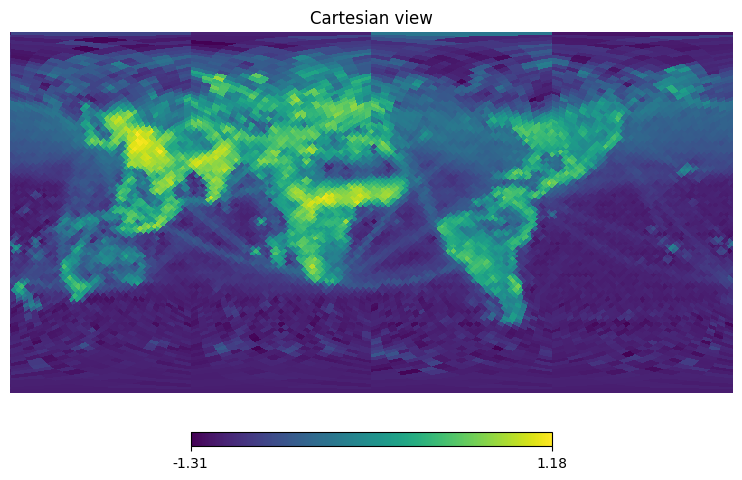

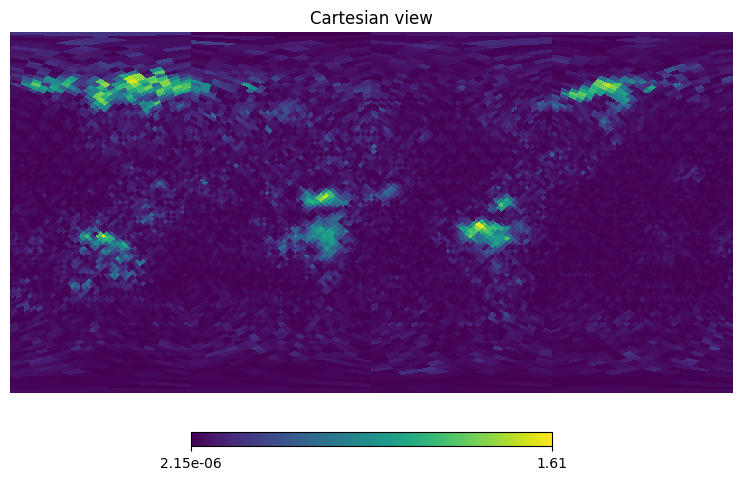

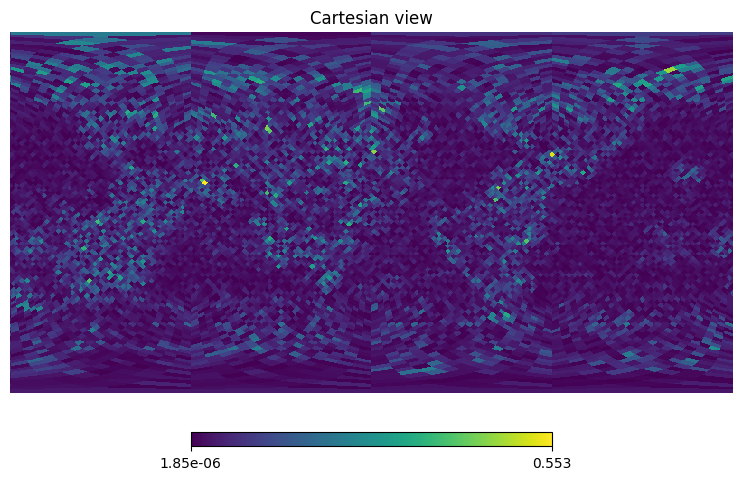

In [27]:
# Evaluate
model.eval()
test_loss = 0.0

plotting_test_samples = []
with torch.no_grad():
    for i, batch in enumerate(test_batches):
        x_batch = batch['input']
        x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
        x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
        
        y_true = x_batch_tensor
        
        out = model({"input_surface": x_batch_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        loss = criterion(y_pred, y_true)
        test_loss += loss.item()

        if i == 0:
            #x_batch_sample = batch['input'][0]
            #print(x_batch_tensor[0,:,:])
            #print(y_pred[0,:,:])

            inp = x_batch_tensor[0,:,:].squeeze() #.T
            cpu_input = inp.cpu()
            print(cpu_input, cpu_input.shape)
            x_co2, x_so2, x_ch4, x_bc = cpu_input
            
            output = y_pred[0,:,:].squeeze() #.T
            cpu_output = output.cpu()
            y_co2, y_so2, y_ch4, y_bc = cpu_output

            y_sanity_check = y_pred[7,:,:].squeeze() #.T
            y_cpu_sanity = y_sanity_check.cpu()
            ys_co2, ys_so2, ys_ch4, ys_bc = y_cpu_sanity

            x_sanity_check = x_batch_tensor[7,:,:].squeeze() #.T
            x_cpu_sanity = x_sanity_check.cpu()
            xs_co2, xs_so2, xs_ch4, xs_bc = x_cpu_sanity
            #healpix_plotting(np.array(co2))
            # healpix_plotting(x_co2.numpy())
            # healpix_plotting(y_co2.detach().numpy())
            healpix_plotting(s_co2.detach().numpy())
            
            # diff = x_co2.numpy() - y_so2.detach().numpy()
            # healpix_plotting(np.abs(diff))
            diff2 = x_co2.numpy() - ys_co2.detach().numpy()
            healpix_plotting(np.abs(diff2))
            diff = x_co2.numpy() - y_co2.detach().numpy()
            healpix_plotting(np.abs(diff))
            
#avg_test_loss = test_loss / len(test_batches)
print(f"Test Loss on {test_experiments}: {avg_test_loss:.6e}")




In [ ]:

    
.detach()
input_v = input_v.squeeze()
print(input_v)
cpu_input_v = input_v.cpu()
inp_co2, inp_so2, inp_ch4, inp_bc = cpu_input_v

output = out["logits_surface"]
output = output.squeeze().T
cpu_output = output.cpu()
co2, so2, ch4, bc = cpu_output

#healpix_plotting(np.array(co2))
healpix_plotting(inp_co2.numpy())
healpix_plotting(co2.detach().numpy())

diff = inp_co2.numpy() - co2.detach().numpy()
healpix_plotting(np.abs(diff))

## Train / Test "normal x -> y"

In [12]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=1, n_upper=1)  # 1 output temperature

model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)



In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
n_epochs = 5

print("\nStarting training...")
for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Shuffle batches each epoch (optional)
    if shuffle:
        import random
        random.shuffle(batches)
    
    for batch in batches:
        # Get batch data
        x_batch = batch['input']  # (B, C, N)
        
        # Apply transform
        x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
        
        # Convert to torch and move to device
        x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
        
        # Target (for autoencoding, same as input)
        y_batch = batch['output']
        y_batch_scaled = apply_log_transform(y_batch, global_mean, global_std)
        y_true = torch.from_numpy(y_batch_scaled).float().to(device)
        
    
        # Forward pass
        optimizer.zero_grad()
        out = model({"input_surface": x_batch_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        # Compute loss
        loss = criterion(y_pred, y_true)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Print batch info
        batch_idx = batch['batch_idx']
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Batch {batch_idx}/{len(batches)} | "
                  f"Loss: {loss.item():.6e} | "
                  f"Sample exp: {batch['metadata'][0]['exp']}")
    
    avg_loss = epoch_loss / len(batches)
    print(f"\n==> Epoch {epoch+1} complete | Avg Loss: {avg_loss:.6e}\n")
print("done")


Starting training...
Epoch 1/5 | Batch 0/387 | Loss: 7.510012e+01 | Sample exp: ssp585
Epoch 1/5 | Batch 10/387 | Loss: 1.515435e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 20/387 | Loss: 4.000920e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 30/387 | Loss: 1.844546e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 40/387 | Loss: 1.172283e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 50/387 | Loss: 6.452098e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 60/387 | Loss: 5.056745e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 70/387 | Loss: 4.459184e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 80/387 | Loss: 3.995191e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 90/387 | Loss: 3.639906e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 100/387 | Loss: 3.359662e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 110/387 | Loss: 3.148688e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 120/387 | Loss: 2.973427e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 130/387 | Loss: 4.819433e-02 | Sample exp: ssp126
Epoch 1/5 | Batch 140/387 | Loss: 3.4

tensor([[-0.1627,  0.0428,  0.2074,  ...,  0.1711,  0.2038, -0.1107],
        [ 0.7824,  0.9901,  1.1887,  ...,  1.0787,  1.1592,  0.8088],
        [-0.1886, -0.0688, -0.0266,  ...,  0.4620,  0.4611,  0.2116],
        [ 0.9954,  1.0174,  1.1403,  ...,  1.7649,  1.8060,  1.4756]]) torch.Size([4, 12288])
Test Loss: 1.683289e-03


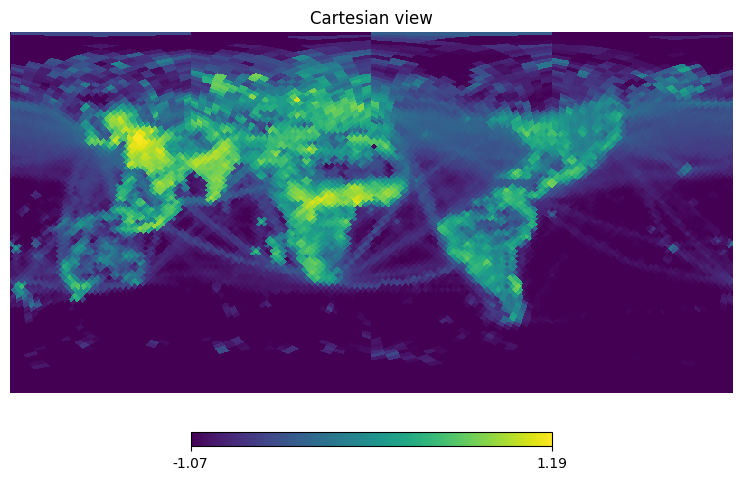

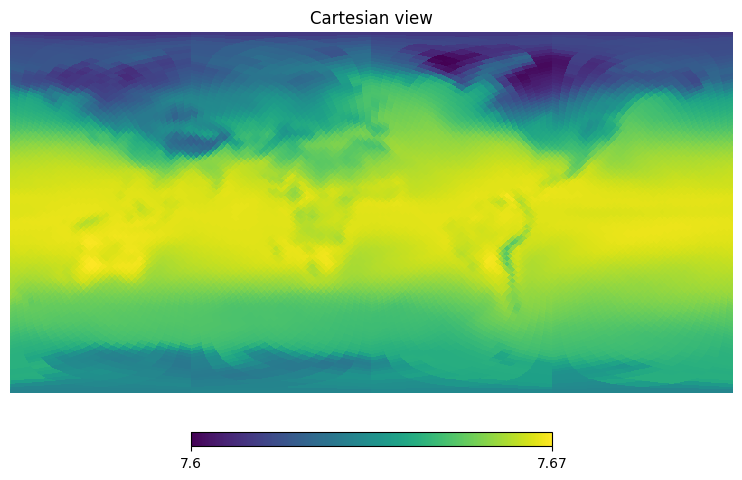

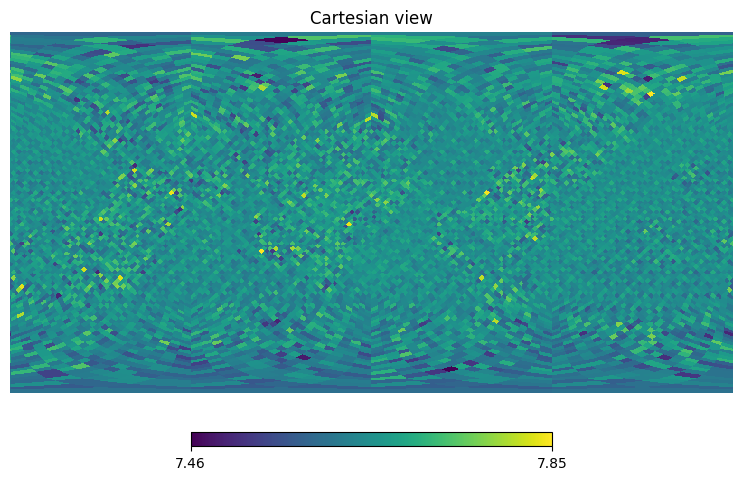

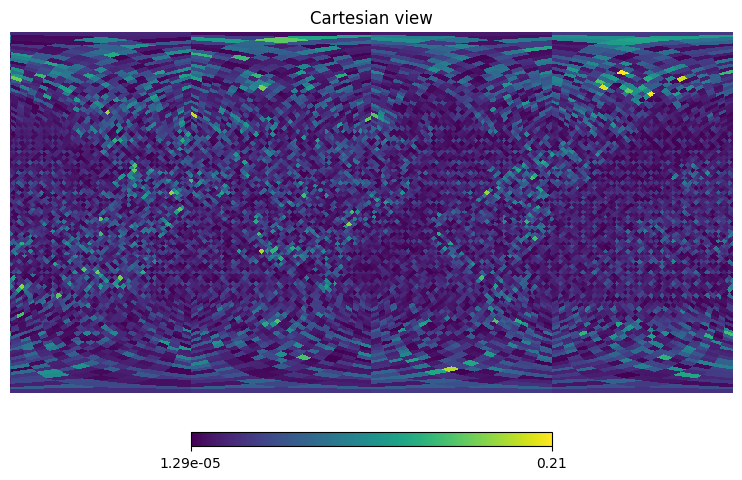

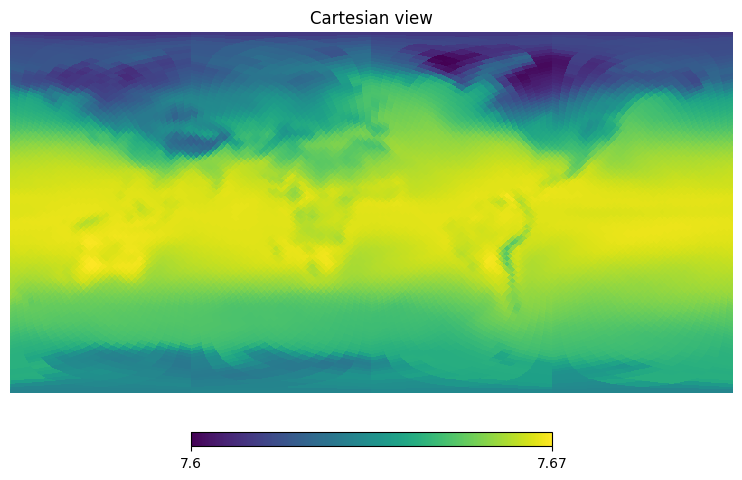

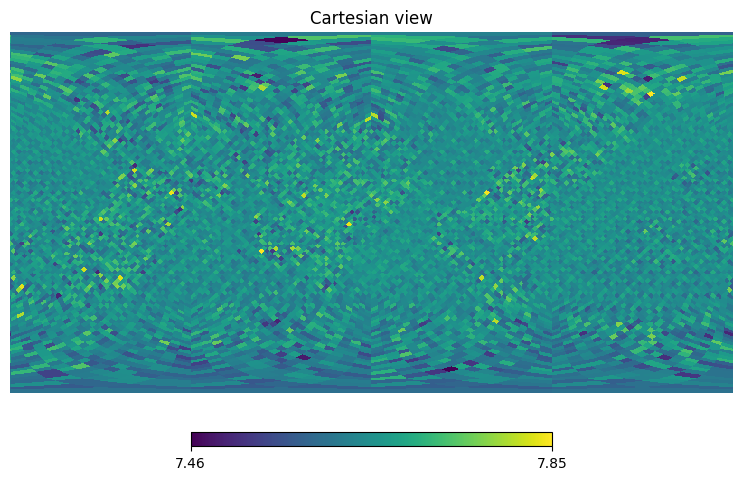

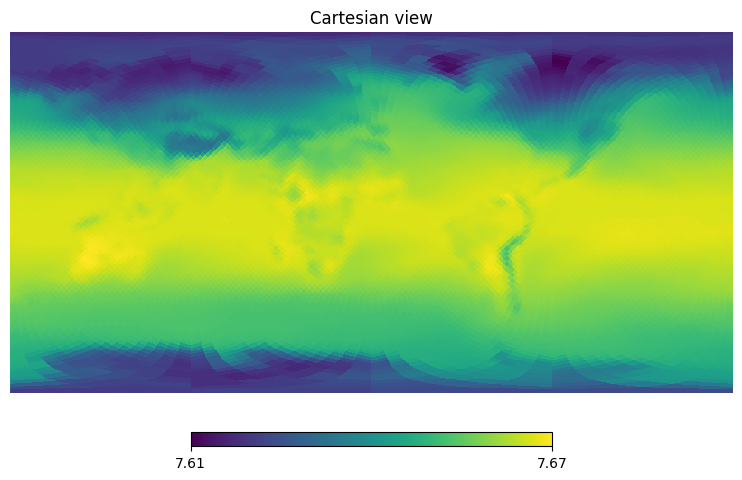

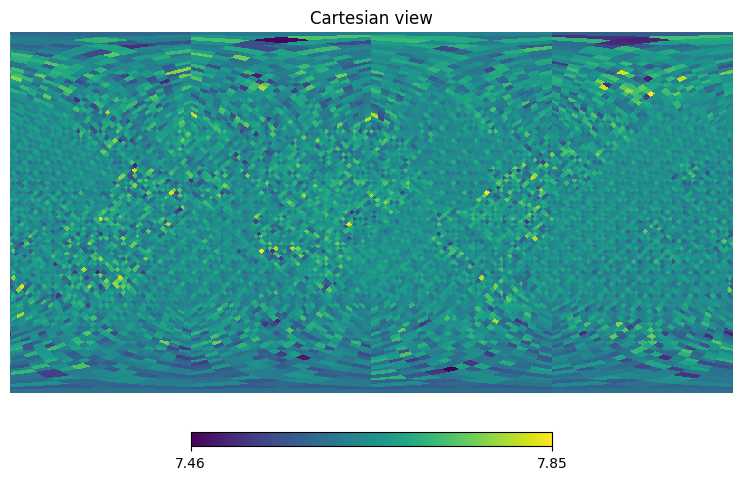

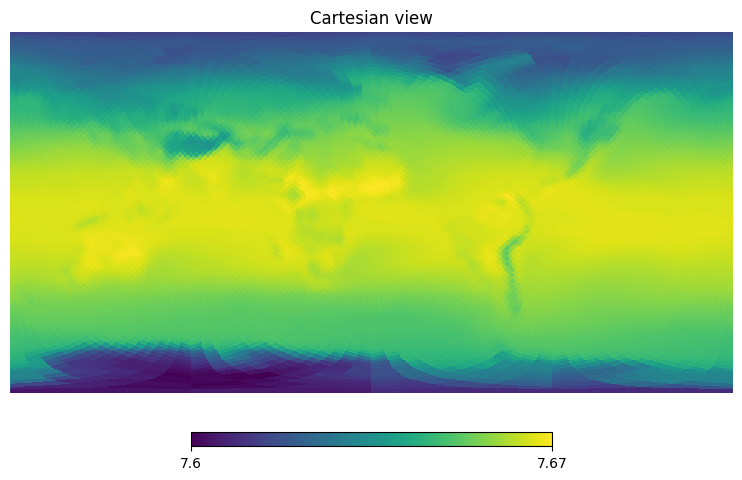

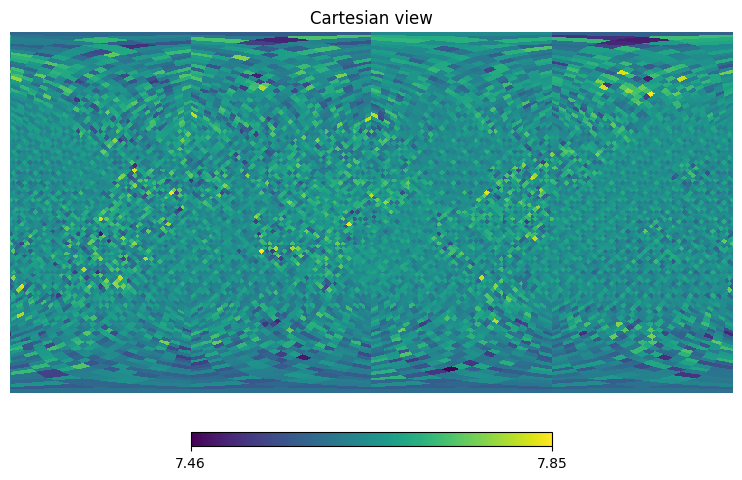

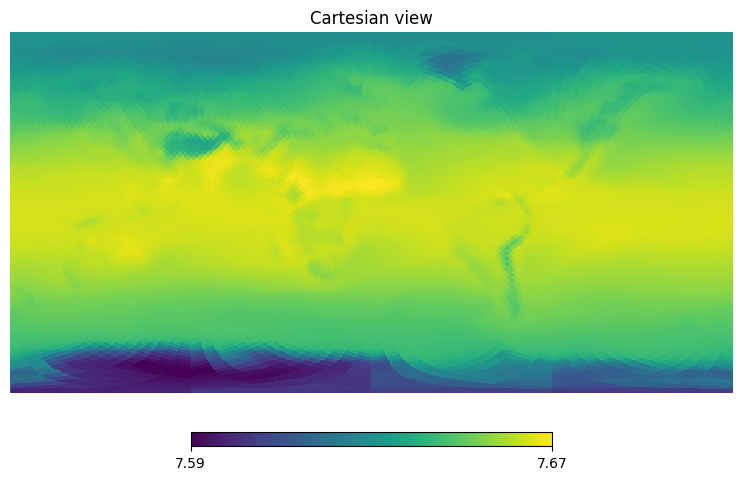

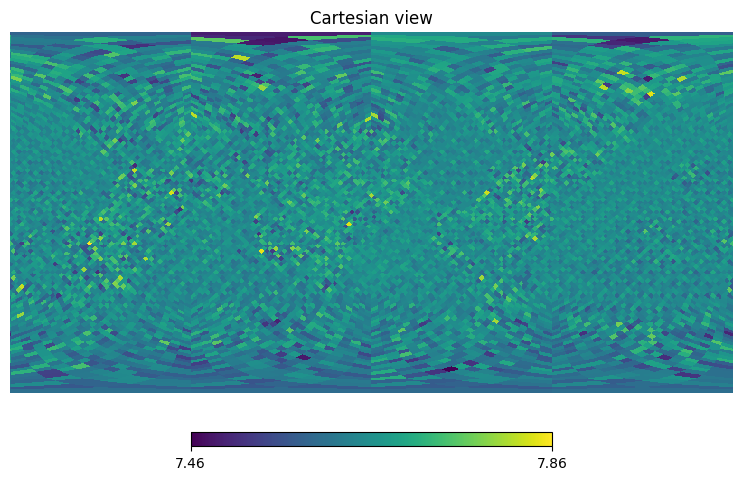

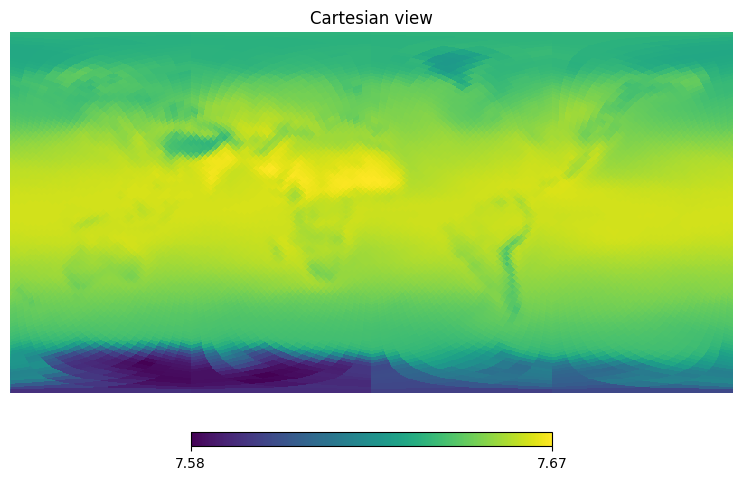

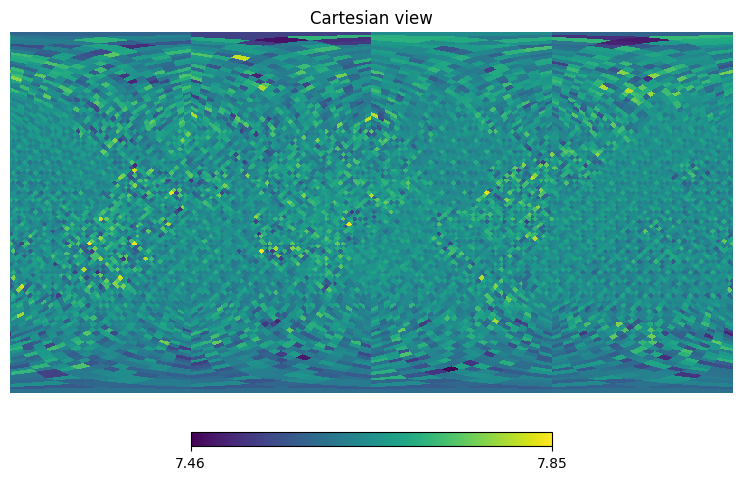

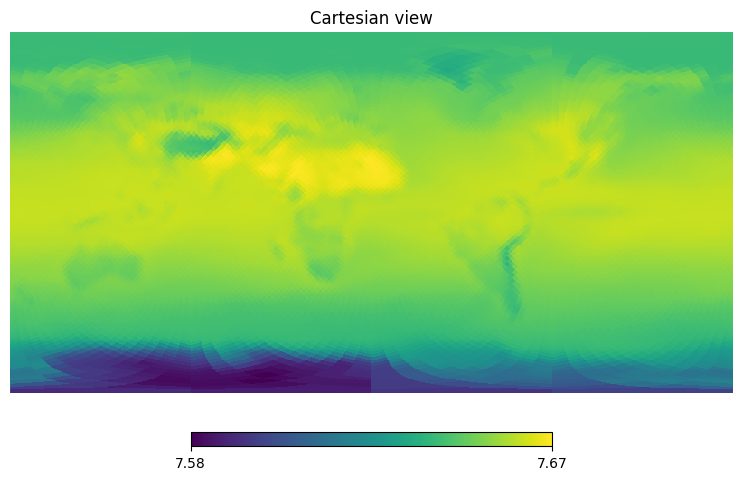

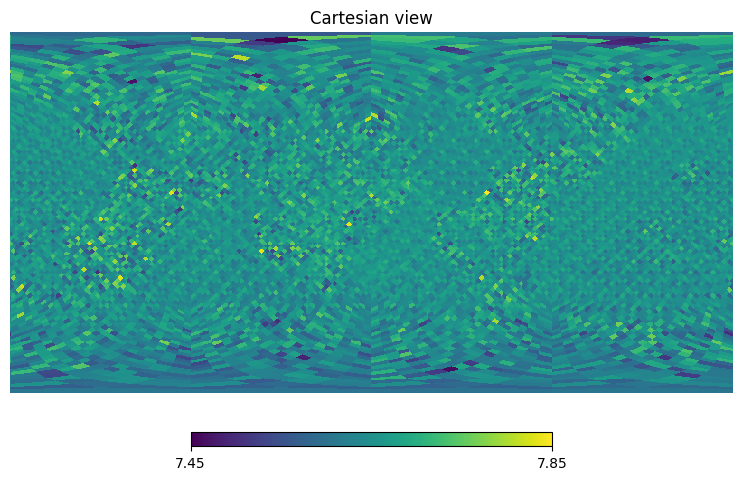

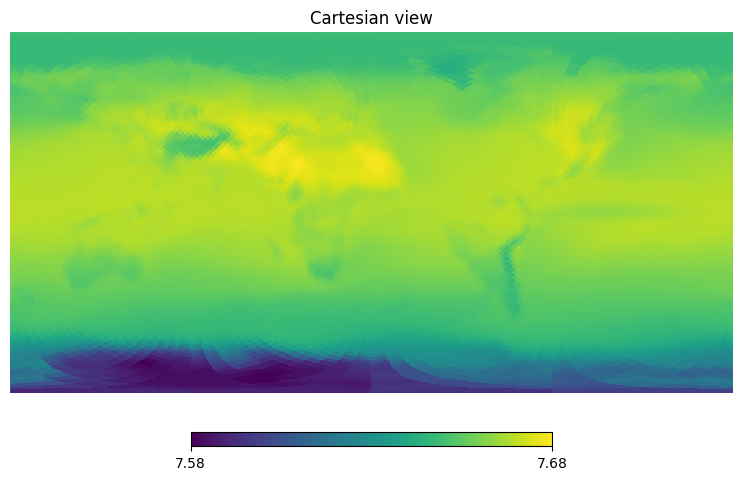

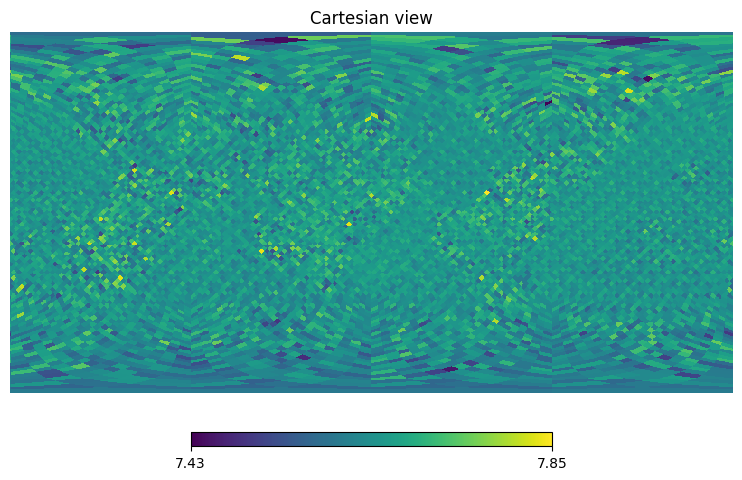

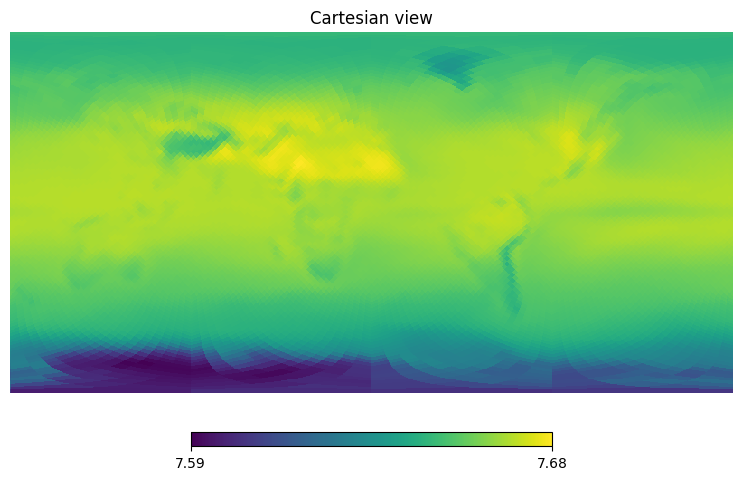

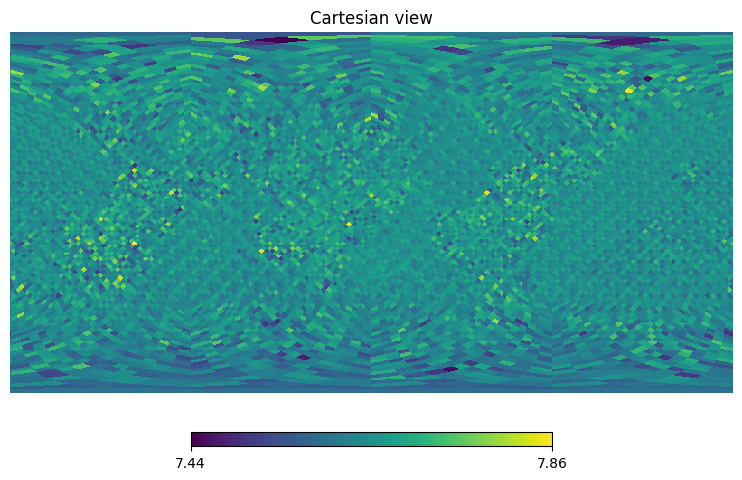

In [16]:
def evaluate(model, test_batches, global_mean, global_std, criterion, device):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_batches):
            # Input: 4 gases
            x_batch = batch['input']
            x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
            x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
            
            # Target: temperature (or whatever outputs you have)
            y_batch = batch['output']
            y_batch_scaled = apply_log_transform(y_batch, global_mean, global_std)
            y_true = torch.from_numpy(y_batch_scaled).float().to(device)
            
            # Forward
            out = model({"input_surface": x_batch_tensor})
            y_pred = out["logits_surface"].permute(0, 2, 1)
            
            # Loss
            loss = criterion(y_pred, y_true)
            test_loss += loss.item()
            
            # Store for analysis (optional)
            all_preds.append(y_pred.cpu())
            all_targets.append(y_true.cpu())

            
            if i == 0:
                #x_batch_sample = batch['input'][0]
                #print(x_batch_tensor[0,:,:])
                #print(y_pred[0,:,:])
    
                inp = x_batch_tensor[0,:,:].squeeze() #.T
                cpu_input = inp.cpu()
                print(cpu_input, cpu_input.shape)
                x_co2, x_so2, x_ch4, x_bc = cpu_input
                
                output = y_true[0,:,:].squeeze() #.T
                cpu_output = output.cpu()
                y_tr = cpu_output
    
                y_pr = y_pred[0,:,:].squeeze() #.T
                y_pr = y_pr.cpu()
                #ys_co2 = y_cpu_sanity
    
                # x_sanity_check = x_batch_tensor[7,:,:].squeeze() #.T
                # x_cpu_sanity = x_sanity_check.cpu()
                # xs_co2, xs_so2, xs_ch4, xs_bc = x_cpu_sanity
                #healpix_plotting(np.array(co2))
                
                healpix_plotting(x_co2.numpy())
                healpix_plotting(y_tr.numpy())
                healpix_plotting(y_pr.numpy())
                diff = y_tr.numpy() - y_pr.detach().numpy()
                healpix_plotting(np.abs(diff))
                # healpix_plotting(y_co2.detach().numpy())
                # healpix_plotting(s_co2.detach().numpy())
                
                # # diff = x_co2.numpy() - y_so2.detach().numpy()
                # # healpix_plotting(np.abs(diff))
                # diff2 = x_co2.numpy() - ys_co2.detach().numpy()
                # healpix_plotting(np.abs(diff2))
                # diff = x_co2.numpy() - y_co2.detach().numpy()
                # healpix_plotting(np.abs(diff))

                for i in range(0, batch_size):
                    output = y_true[i,:,:].squeeze() #.T
                    cpu_output = output.cpu()
                    y_tr = cpu_output
        
                    y_pr = y_pred[i,:,:].squeeze() #.T
                    y_pr = y_pr.cpu()
                    healpix_plotting(y_tr.numpy())
                    healpix_plotting(y_pr.numpy())

    avg_test_loss = test_loss / len(test_batches)
    print(f"Test Loss: {avg_test_loss:.6e}")
    
    return avg_test_loss, all_preds, all_targets

# Use it:
test_loss, preds, targets = evaluate(model, test_batches, global_mean, global_std, criterion, device)

In [19]:
# ============================================================================
# COMPUTE SEPARATE STATISTICS FOR INPUTS AND OUTPUTS
# ============================================================================

from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=1, n_upper=1)  # 1 output temperature

model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)

# Input statistics (gases - use log scaling)
all_inputs_log = np.log10(np.clip(all_inputs, 1e-15, None) + 1e-15)
input_mean = all_inputs_log.mean()
input_std = all_inputs_log.std()

# Output statistics (temperature - NO log, just standardize)
all_outputs_flat = all_outputs.flatten()
output_mean = all_outputs_flat.mean()
output_std = all_outputs_flat.std()

print(f"Input (log gases): mean={input_mean:.6f}, std={input_std:.6f}")
print(f"Output (temperature): mean={output_mean:.6f}, std={output_std:.6f}")

# ============================================================================
# SEPARATE TRANSFORM FUNCTIONS
# ============================================================================

def transform_inputs(data, mean, std, eps=1e-12):
    """Log transform for gas concentrations"""
    data_log = np.log10(np.clip(data, 1e-15, None) + 1e-15)
    return (data_log - mean) / max(std, eps)

def transform_outputs(data, mean, std, eps=1e-12):
    """Simple standardization for temperature"""
    return (data - mean) / max(std, eps)

# ============================================================================
# TRAINING LOOP - USE BOTH TRANSFORMS
# ============================================================================


Input (log gases): mean=-12.587745, std=1.965315
Output (temperature): mean=289.597046, std=15.076720


In [20]:
model.train()
for epoch in range(n_epochs):
    for batch in batches:
        # Transform inputs (gases with log)
        x_batch = batch['input']
        x_scaled = transform_inputs(x_batch, input_mean, input_std)
        x_tensor = torch.from_numpy(x_scaled).float().to(device)
        
        # Transform outputs (temperature without log)
        y_batch = batch['output']
        y_scaled = transform_outputs(y_batch, output_mean, output_std)
        y_true = torch.from_numpy(y_scaled).float().to(device)
        
        # Forward pass
        optimizer.zero_grad()
        out = model({"input_surface": x_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        
        # Print batch info
        batch_idx = batch['batch_idx']
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Batch {batch_idx}/{len(batches)} | "
                  f"Loss: {loss.item():.6e} | "
                  f"Sample exp: {batch['metadata'][0]['exp']}")
    
    avg_loss = epoch_loss / len(batches)
    print(f"\n==> Epoch {epoch+1} complete | Avg Loss: {avg_loss:.6e}\n")

Epoch 1/5 | Batch 0/387 | Loss: 7.477867e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 50/387 | Loss: 6.774795e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 100/387 | Loss: 6.812660e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 150/387 | Loss: 7.353149e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 200/387 | Loss: 7.051984e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 250/387 | Loss: 7.046974e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 300/387 | Loss: 7.169533e+00 | Sample exp: ssp370
Epoch 1/5 | Batch 350/387 | Loss: 6.795452e+00 | Sample exp: ssp370

==> Epoch 1 complete | Avg Loss: 1.787862e-03

Epoch 2/5 | Batch 0/387 | Loss: 7.477867e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 50/387 | Loss: 6.774795e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 100/387 | Loss: 6.812660e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 150/387 | Loss: 7.353149e+00 | Sample exp: ssp126
Epoch 2/5 | Batch 200/387 | Loss: 7.051984e+00 | Sample exp: ssp126
Epoch 2/5 | Batch 250/387 | Loss: 7.046974e+00 | Sample exp: ssp126
Epoch 

In [21]:

# ============================================================================
# EVALUATION - SAME SEPARATE TRANSFORMS
# ============================================================================

def evaluate(model, test_batches, input_mean, input_std, output_mean, output_std, criterion, device):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch in test_batches:
            x_batch = transform_inputs(batch['input'], input_mean, input_std)
            x_tensor = torch.from_numpy(x_batch).float().to(device)
            
            y_batch = transform_outputs(batch['output'], output_mean, output_std)
            y_true = torch.from_numpy(y_batch).float().to(device)
            
            out = model({"input_surface": x_tensor})
            y_pred = out["logits_surface"].permute(0, 2, 1)
            
            loss = criterion(y_pred, y_true)
            test_loss += loss.item()
    
    return test_loss / len(test_batches)

# Call it with both sets of statistics
test_loss = evaluate(model, test_batches, input_mean, input_std, 
                     output_mean, output_std, criterion, device)

In [22]:
test_loss

7.153786670329959